# S&P 500 prediction

`Dataset to prepare:` 
* (t)&(t-1) historical stock price (Yahoo Finance)
* oil & gas price (Yahoo Finance)
* unemployment rate (US Bureau of Labor)
* prime rate (banks)  
* Other stock exchange index(Russell 2000, Nasdaq)
* trading volume (Yahoo Finance)
* CPI (US Bureau of Labor)
* Bond yield(treasury bond/bill) (Yahoo Finance)
* Consumer_Sentiment_Index(Nasdaq)
* gold / gold future
* S&P monthly PER(Nasdaq)
* S&P monthly Dividend rate(Nasdaq)
* S&P monthly earning yield ratio(Nasdaq)
* +a: future price (crude oil etc)     

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Oldest date is 1928-01-06 (Volume records since 1951-Dec-24)
SP = pd.read_csv('data/S&P500.csv')
SP['Date']= pd.to_datetime(SP['Date'])
SP['Year'] = SP['Date'].dt.year
SP['Month'] = SP['Date'].dt.month
SP['Day'] = SP['Date'].dt.day

# Manually converting 2027 ~ 2072 to Year 1927 ~ 1972 and combine 'Date' again
SP['Year'] = np.where((SP['Year'] >= 2027), SP['Year'] - 100, SP.Year)
SP['Date_adj'] = pd.to_datetime(SP[['Year','Month','Day']])
SP = SP.drop(['Date','Year','Month','Day'], axis=1)
SP = SP.rename(columns = {'Open':'S&P_Open','Close*':'S&P_Close','Volume':'S&P_Volume','Date_adj':'Date'})
SP = SP.set_index('Date')
SP = SP.drop(['High','Low','Adj Close**'], axis=1)
SP.replace(to_replace=',', value='', inplace=True, regex = True)
SP.replace(to_replace='-', value=np.nan, inplace=True)
SP = SP.astype(float)

In [3]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23783 entries, 2022-09-02 to 1927-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S&P_Open    23783 non-null  float64
 1   S&P_Close   23783 non-null  float64
 2   S&P_Volume  18287 non-null  float64
dtypes: float64(3)
memory usage: 743.2 KB


In [4]:
SP['Close_t-1'] = SP['S&P_Close'].shift(-1)
SP['return(%)'] = (SP['S&P_Close']-SP['Close_t-1'])/SP['Close_t-1'] * 100
# return_class: if daily return is higher than 0.5% -> 1 (positive), if between -0.5 to 0.5% -> 0(neutral)
# if daily return is lower than -0.5% then -1 (negative)
SP['return_class'] = SP['return(%)'].apply(lambda x:  if x >= 0.5 
                                              else( 1 if x < 0.5 and x > -0.5 else 0))


In [5]:
SP['Close_t+1'] = SP['S&P_Close'].shift(1)
SP['t+1_return_class'] = SP['return_class'].shift(1)
SP.head(2)

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return_class
Date,,,,,,,,
2022-09-02,3994.66,3924.26,4.134920e+09,3966.85,-1.073648,0,NaN,NaN
2022-09-01,3936.73,3966.85,3.754570e+09,3955.00,0.299621,1,3924.26,0.0


`New addition: Russell, gold, gold_future, nasdaq, nikkei, fx, volatility`

In [6]:
Russell = pd.read_csv('data/Russell2000_daily.csv')
Russell = Russell.drop(['High','Low','Adj Close'], axis=1)
Russell['Date']= pd.to_datetime(Russell['Date'])
Russell = Russell.rename(columns = {'Open':'R_Open','Close':'R_Close','Volume':'R_Volume'})
Russell.head(2)

,Date,R_Open,R_Close,R_Volume
0,1987-09-10,167.440002,168.970001,179800000
1,1987-09-11,168.970001,170.539993,178000000


In [7]:
gold = pd.read_csv('data/gold.csv')
gold = gold.drop(['High','Low','Adj Close**'], axis=1)
gold['Date']= pd.to_datetime(gold['Date'])
gold = gold.rename(columns = {'Open':'G_Open','Close*':'G_Close','Volume':'G_Volume'})
gold = gold.set_index('Date')
gold.replace(to_replace=',', value='', inplace=True, regex = True)
gold.replace(to_replace='-', value=np.nan, inplace=True)
gold = gold.astype(float)
gold.head()

,G_Open,G_Close,G_Volume
Date,,,
2022-08-31,1718.3,1712.8,385.0
2022-08-30,1736.4,1723.2,385.0
2022-08-29,1732.4,1736.6,950.0
2022-08-26,1754.0,1736.1,202.0
2022-08-25,1761.6,1757.7,172.0


In [8]:
gold_future = pd.read_csv('data/gold_future_daily.csv')
gold_future = gold_future.drop(['High','Low','Adj Close**'], axis=1)
gold_future['Date']= pd.to_datetime(gold_future['Date'])
gold_future = gold_future.rename(columns = {'Open':'GF_Open','Close*':'GF_Close','Volume':'GF_Volume'})
gold_future = gold_future.set_index('Date')
gold_future.replace(to_replace=',', value='', inplace=True, regex = True)
gold_future.replace(to_replace='-', value=np.nan, inplace=True)
gold_future = gold_future.astype(float)
gold_future.head()

,GF_Open,GF_Close,GF_Volume
Date,,,
2022-09-06,1709.7,1700.4,182.0
2022-09-05,NaN,NaN,NaN
2022-09-02,1703.4,1709.8,182.0
2022-09-01,1707.9,1696.6,683.0
2022-08-31,1718.3,1712.8,2133.0


In [9]:
nasdaq = pd.read_csv('data/Nasdaq_daily.csv')
nasdaq = nasdaq.drop(['High','Low','Adj Close'], axis=1)
nasdaq['Date']= pd.to_datetime(nasdaq['Date'])
nasdaq = nasdaq.rename(columns = {'Open':'Nas_Open','Close':'Nas_Close','Volume':'Nas_Volume'})
nasdaq.head(2)

,Date,Nas_Open,Nas_Close,Nas_Volume
0,1971-02-05,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,0


In [10]:
nikkei = pd.read_csv('data/Nikkei_index_daily.csv')
nikkei = nikkei.drop(['High','Low','Adj Close'], axis=1)
nikkei['Date']= pd.to_datetime(nikkei['Date'])
nikkei = nikkei.rename(columns = {'Open':'Nk_Open','Close':'Nk_Close','Volume':'Nk_Volume'})
nikkei.head(2)

,Date,Nk_Open,Nk_Close,Nk_Volume
0,1965-01-05,1257.719971,1257.719971,0.0
1,1965-01-06,1263.989990,1263.989990,0.0


In [11]:
fx = pd.read_csv('data/USD_CAD Historical Data_daily.csv')
fx = fx.drop(['Open','High','Low','Vol.'], axis=1)
fx['Date']= pd.to_datetime(fx['Date'])
fx = fx.rename(columns = {'Price':'fx_Price','Change %':'fx_change%'})
fx.replace(to_replace='%', value='', inplace=True, regex = True)
fx['fx_change%'] = fx['fx_change%'].astype(float)
fx.head(2)

,Date,fx_Price,fx_change%
0,2022-09-07,1.3112,-0.30
1,2022-09-06,1.3152,0.08


In [12]:
volatility = pd.read_csv('data/CBOE_volatility_index_daily.csv')
volatility = volatility.drop(['High','Low','Adj Close','Volume'], axis=1)
volatility['Date']= pd.to_datetime(volatility['Date'])
volatility = volatility.rename(columns = {'Open':'vo_Open','Close':'vo_Close'})
volatility.head(2)

,Date,vo_Open,vo_Close
0,1990-01-02,17.240000,17.240000
1,1990-01-03,18.190001,18.190001


In [13]:
# Oldest date is 1960-01-04
treasury_3m = pd.read_csv('data/treasury_3m_yield.csv')
treasury_3m['Date']= pd.to_datetime(treasury_3m['Date'])
treasury_3m = treasury_3m[['Date','Close']]
treasury_3m = treasury_3m.rename(columns={'Close':'t_3m_Close'})
treasury_3m.tail(2)

,Date,t_3m_Close
19479,2022-08-30,2.873
19480,2022-08-31,2.860


In [14]:
# Oldest date is 1962-01-04
treasury_10y = pd.read_csv('data/treasury_10yr_yield.csv')
treasury_10y['Date']= pd.to_datetime(treasury_10y['Date'])
treasury_10y = treasury_10y[['Date','Close']]
treasury_10y = treasury_10y.rename(columns={'Close':'t_10y_Close'})
treasury_10y.tail(2)

,Date,t_10y_Close
18854,2022-08-30,3.11
18855,2022-08-31,3.133


In [15]:
cpi = pd.read_csv('data/CPI.csv')
cpi['Month'] = cpi['Period'].str.replace('M','').astype(int)
cpi['Day'] = "01"
cpi['Date'] = pd.to_datetime(cpi[['Year','Month','Day']])
cpi = cpi.drop(['Year','Period','Month','Day','Series Id'], axis=1)
cpi = cpi.rename(columns={'Value':'cpi_Value','1-Month percent change':'cpi_MoM%'})
cpi.head(2)

,cpi_Value,cpi_MoM%,Date
0,21.48,0.7,1947-01-01
1,21.62,1.8,1947-02-01


In [16]:
# Oldest info - 2000-08-23
oil = pd.read_csv('data/Crude_1986.csv')
oil['Date'] = pd.to_datetime(oil['Date'])
oil = oil.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'oil_Price'})

oil.head(2)

,Date,oil_Price
0,1986-01-02,25.56
1,1986-01-03,26.00


In [17]:
unemployment = pd.read_csv('data/unemployment_rate.csv')
unemployment['Month'] = unemployment['Period'].str.replace('M','').astype(int)
unemployment['Day'] = "01"
unemployment['Date'] = pd.to_datetime(unemployment[['Year','Month','Day']])
unemployment = unemployment.drop(['Year','Period','Month','Day', 'Series id'], axis=1)
unemployment = unemployment.rename(columns={'Value':'unemp_rate'})
unemployment.head(2)

,unemp_rate,Date
0,3.4,1948-01-01
1,3.8,1948-02-01


In [18]:
SP_PER = pd.read_csv('data/SP500_PE_RATIO_MONTH.csv')
SP_PER['Date']= pd.to_datetime(SP_PER['Date'])
SP_PER = SP_PER.rename(columns={'Value':'PE_Ratio'})
SP_PER.tail(2)

,Date,PE_Ratio
1844,1871-02-01,11.25
1845,1871-01-01,11.10


In [19]:
SP_DIV = pd.read_csv('data/MULTPL-SP500_DIV_MONTH.csv')
SP_DIV['Date']= pd.to_datetime(SP_DIV['Date'])
SP_DIV = SP_DIV.rename(columns={'Value':'Div_Ratio'})
SP_DIV.tail()

,Date,Div_Ratio
1813,1871-05-31,6.28
1814,1871-04-30,6.13
1815,1871-03-31,5.91
1816,1871-02-28,6.00
1817,1871-01-31,6.18


In [20]:
SP_EYR = pd.read_csv('data/MULTPL-SP500_EARNINGS_YIELD_MONTH.csv')
SP_EYR['Date']= pd.to_datetime(SP_EYR['Date'])
SP_EYR = SP_EYR.rename(columns={'Value':'EY_Ratio'})
SP_EYR.tail(2)

,Date,EY_Ratio
1844,1871-02-01,8.89
1845,1871-01-01,9.01


In [21]:
CSI = pd.read_csv('data/Consumer_Sentiment_Index.csv')
CSI['Date']= pd.to_datetime(CSI['Date'])
CSI = CSI.rename(columns={'Index':'CS_Index'})
CSI.head(2)

,Date,CS_Index
0,2022-07-31,51.5
1,2022-06-30,50.0


In [22]:
PutCallRatio = pd.read_csv('data/spxputcallratio.csv')
PutCallRatio['Date'] = pd.to_datetime(PutCallRatio['Date'])
PutCallRatio = PutCallRatio.drop(['SPX Put Volume','SPX Call Volume','Total SPX Options Volume'], axis=1)
PutCallRatio = PutCallRatio.rename(columns={'SPX Put/Call Ratio':'Put/Call_Ratio'})
PutCallRatio.head()

,Date,Put/Call_Ratio
0,2010-07-06,1.91
1,2010-07-07,0.91
2,2010-07-08,1.12
3,2010-07-09,1.20
4,2010-07-12,1.49


In [23]:
# Merging all data into one file
Filename = [treasury_10y,cpi, oil, unemployment, SP_PER, SP_DIV, SP_EYR, CSI, 
            PutCallRatio, Russell, gold, gold_future, nasdaq, nikkei, fx, volatility]

SP_all = SP.merge(treasury_3m, on='Date', how='left')
for file in Filename:
    SP_all = SP_all.merge(file, on='Date', how='left')

In [24]:
cols_tobfill = ['t_3m_Close','t_10y_Close','unemp_rate','cpi_Value', 'cpi_MoM%','oil_Price','PE_Ratio',
                'Div_Ratio','EY_Ratio','CS_Index','Put/Call_Ratio', 'R_Open', 'R_Close', 'R_Volume',
                'G_Open', 'G_Close', 'G_Volume', 'GF_Open', 'GF_Close', 'GF_Volume', 'fx_Price','fx_change%']

for col in cols_tobfill:
    SP_all[col].fillna(method='bfill', inplace=True)         

In [25]:
SP_all[['S&P_Open','S&P_Close','S&P_Volume','t_10y_Close']] = SP_all[['S&P_Open','S&P_Close','S&P_Volume','t_10y_Close']].astype(float)

In [26]:
cols_toffill = ['S&P_Volume','t_3m_Close','t_10y_Close','cpi_Value','oil_Price','PE_Ratio','Div_Ratio',
                'EY_Ratio', 'R_Open', 'R_Close', 'R_Volume', 'G_Open', 'G_Close', 'G_Volume', 'GF_Open',
                'GF_Close', 'GF_Volume', 'Nas_Open', 'Nas_Close', 'Nas_Volume', 'Nk_Open', 
                'Nk_Close', 'Nk_Volume','fx_Price', 'fx_change%', 'vo_Open', 'vo_Close']

for col in cols_toffill:
    SP_all[col].fillna(method='ffill', inplace=True)         

In [27]:
cols_tofill_mean = ['cpi_MoM%','unemp_rate','CS_Index','Put/Call_Ratio']
for col in cols_tofill_mean:
    SP_all[col].fillna(SP_all[col].mean(), inplace=True)

In [28]:
#SP_all = SP_all[SP_all['Date'] >= '2000-09-01']
#SP_all = SP_all.dropna()
SP_all['Year'] = SP_all['Date'].dt.year
SP_all['Month'] = SP_all['Date'].dt.month
SP_all['Day'] = SP_all['Date'].dt.day
SP_all['Dayofweek'] = SP_all['Date'].dt.dayofweek
SP_all = SP_all.set_index('Date')

In [29]:
SP_all.head()

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return_class,t_3m_Close,t_10y_Close,...,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close,Year,Month,Day,Dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,3994.66,3924.26,4.134920e+09,3966.85,-1.073648,0,NaN,NaN,2.860,3.133,...,27650.839844,58800000.0,1.3132,-0.15,25.510000,25.469999,2022,9,2,4
2022-09-01,3936.73,3966.85,3.754570e+09,3955.00,0.299621,1,3924.26,0.0,2.860,3.133,...,27661.470703,68900000.0,1.3152,0.19,26.879999,25.559999,2022,9,1,3
2022-08-31,4000.67,3955.00,3.797860e+09,3986.16,-0.781705,0,3966.85,1.0,2.860,3.133,...,28091.529297,86200000.0,1.3127,0.27,25.860001,25.870001,2022,8,31,2
2022-08-30,4041.25,3986.16,3.190580e+09,4030.61,-1.102811,0,3955.00,0.0,2.873,3.110,...,28195.580078,60700000.0,1.3092,0.62,25.750000,26.209999,2022,8,30,1
2022-08-29,4034.58,4030.61,2.963020e+09,4057.66,-0.666640,0,3986.16,0.0,2.798,3.110,...,27878.960938,64100000.0,1.3011,-0.17,26.860001,26.209999,2022,8,29,0


In [30]:
print(SP_all['return_class'].value_counts())

1    11869
2     6327
0     5587
Name: return_class, dtype: int64


In [31]:
SP_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23783 entries, 2022-09-02 to 1927-12-30
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   S&P_Open          23783 non-null  float64
 1   S&P_Close         23783 non-null  float64
 2   S&P_Volume        23783 non-null  float64
 3   Close_t-1         23782 non-null  float64
 4   return(%)         23782 non-null  float64
 5   return_class      23783 non-null  int64  
 6   Close_t+1         23782 non-null  float64
 7   t+1_return_class  23782 non-null  float64
 8   t_3m_Close        23783 non-null  float64
 9   t_10y_Close       23783 non-null  float64
 10  cpi_Value         23783 non-null  float64
 11  cpi_MoM%          23783 non-null  float64
 12  oil_Price         23783 non-null  float64
 13  unemp_rate        23783 non-null  float64
 14  PE_Ratio          23783 non-null  float64
 15  Div_Ratio         23783 non-null  float64
 16  EY_Ratio          23783

In [32]:
SP_all.to_csv('SP_all_daily.csv')

### EDA 

In [33]:
# Summary statistics
SP_all.describe()

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return_class,t_3m_Close,t_10y_Close,...,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close,Year,Month,Day,Dayofweek
count,23783.000000,23783.000000,2.378300e+04,23782.000000,23782.000000,23783.000000,23782.000000,23782.000000,23783.000000,23783.000000,...,23783.000000,2.378300e+04,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000
mean,538.431527,558.740804,8.302106e+08,558.599288,0.029921,1.031115,558.763555,1.031158,4.411917,5.252829,...,8544.970422,2.496485e+07,1.223417,0.137329,18.087401,18.058748,1974.927343,6.504226,15.758273,2.012446
std,894.894916,883.623872,1.539213e+09,883.372892,1.198454,0.707106,883.635484,0.707089,2.615001,2.563198,...,8675.915720,5.359077e+07,0.105701,0.317722,4.893232,4.840266,27.313093,3.427391,8.741302,1.404731
min,0.000000,4.400000,6.800000e+05,4.400000,-20.466926,0.000000,4.400000,0.000000,-0.105000,0.499000,...,1020.489990,0.000000e+00,0.921700,-3.700000,9.010000,9.140000,1927.000000,1.000000,1.000000,0.000000
25%,9.440000,24.260000,1.400000e+06,24.260000,-0.454650,1.000000,24.260000,1.000000,3.250000,4.060000,...,1257.719971,0.000000e+00,1.189500,0.060000,17.240000,17.240000,1951.000000,4.000000,8.000000,1.000000
50%,37.290000,100.800000,1.861000e+07,100.800000,0.048600,1.000000,100.805000,1.000000,4.520000,4.060000,...,4626.470215,0.000000e+00,1.189500,0.240000,17.240000,17.240000,1975.000000,7.000000,16.000000,2.000000
75%,926.540000,927.300000,7.194000e+08,927.060000,0.544451,2.000000,927.335000,2.000000,5.090000,6.555500,...,15426.554688,0.000000e+00,1.246650,0.240000,17.240000,17.240000,1999.000000,9.000000,23.000000,3.000000
max,4804.510000,4796.560000,1.145623e+10,4796.560000,16.609589,2.000000,4796.560000,2.000000,17.139999,15.840000,...,38915.871094,5.952000e+08,1.614500,3.340000,82.690002,82.690002,2022.000000,12.000000,31.000000,4.000000


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 8.000e+00,
        1.500e+01, 2.100e+01, 2.700e+01, 5.900e+01, 9.700e+01, 2.270e+02,
        4.390e+02, 1.266e+03, 3.828e+03, 9.248e+03, 5.697e+03, 1.815e+03,
        5.540e+02, 2.170e+02, 9.600e+01, 5.600e+01, 3.400e+01, 8.000e+00,
        1.300e+01, 1.400e+01, 3.000e+00, 6.000e+00, 6.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-20.46692607, -19.72539577, -18.98386547, -18.24233516,
        -17.50080486, -16.75927456, -16.01774426, -15.27621395,
        -14.53468365, -13.79315335, -13.05162305, -12.31009275,
        -11.56856244, -10.82703214, -10.08550184,  -9.34397154,
         -8.60244123,  -7.86091093,  -7.11938063,  -6.37785033,
         -5.63632003,  -4.89478972,  -4.15325942,  -3.41

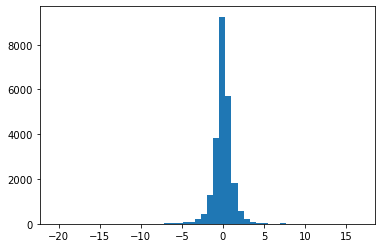

In [35]:
plt.hist(SP_all['return(%)'], bins = 50)

In [36]:
SP_all.to_csv('SP_all_daily.csv')

### Monthly data

In [37]:
# Oldest date is 1928-01-06 (Volume records since 1951-Dec-24)
SP_monthly = pd.read_csv('data/SP_monthly.csv')
SP_monthly['Date'] = pd.to_datetime(SP_monthly['Date'])
SP_monthly = SP_monthly.drop(['High','Low','Adj Close**'], axis=1)
SP_monthly = SP_monthly.rename(columns = {'Open':'S&P_Open','Close*':'S&P_Close','Volume':'S&P_Volume','Date_adj':'Date'})
SP_monthly = SP_monthly.set_index('Date')
SP_monthly.replace(to_replace=',', value='', inplace=True, regex = True)
SP_monthly.replace(to_replace='-', value=np.nan, inplace=True)
SP_monthly.head(2)

,S&P_Open,S&P_Close,S&P_Volume
Date,,,
2022-09-01,3936.73,3908.19,7889490000
2022-08-01,4112.38,3955.00,78088520000


In [38]:
SP_monthly = SP_monthly.astype(float)
SP_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 453 entries, 2022-09-01 to 1985-01-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S&P_Open    453 non-null    float64
 1   S&P_Close   453 non-null    float64
 2   S&P_Volume  453 non-null    float64
dtypes: float64(3)
memory usage: 14.2 KB


In [39]:
SP_monthly['Close_t-1'] = SP_monthly['S&P_Close'].shift(-1)
SP_monthly['return(%)'] = (SP_monthly['S&P_Close']-SP_monthly['Close_t-1'])/SP_monthly['Close_t-1'] * 100
# return_class: if daily return is higher than 0.5% -> 1 (positive), if between -0.5 to 0.5% -> 0(neutral)
# if daily return is lower than -0.5% then -1 (negative)

# Multiclass classification
SP_monthly['return_class'] = SP_monthly['return(%)'].apply(lambda x: 2 if x >= 3 
                                              else( 1 if x < 3 and x > -3 else 0))

# Binary classification
# SP_monthly['return_class'] = SP_monthly['return(%)'].apply(lambda x: 1 if x > 0 else 0)
SP_monthly.head(5)

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class
Date,,,,,,
2022-09-01,3936.73,3908.19,7.889490e+09,3955.00,-1.183565,1
2022-08-01,4112.38,3955.00,7.808852e+10,4130.29,-4.244012,0
2022-07-01,3781.00,4130.29,6.802114e+10,3785.38,9.111635,2
2022-06-01,4149.78,3785.38,8.679906e+10,4132.15,-8.391999,0
2022-05-01,4130.61,4132.15,8.912813e+10,4131.93,0.005324,1


In [40]:
SP_monthly['Close_t+1'] = SP_monthly['S&P_Close'].shift(1)
SP_monthly['t+1_return(%)'] = SP_monthly['return(%)'].shift(1)
SP_monthly['t+1_return_class'] = SP_monthly['return_class'].shift(1)

In [41]:
SP_monthly['return_class'].value_counts()

1    177
2    177
0     99
Name: return_class, dtype: int64

In [42]:
Russell = pd.read_csv('data/Russell2000_monthly.csv')
Russell = Russell.drop(['High','Low','Adj Close'], axis=1)
Russell['Date']= pd.to_datetime(Russell['Date'])
Russell = Russell.rename(columns = {'Open':'R_Open','Close':'R_Close','Volume':'R_Volume'})
Russell.head(2)

,Date,R_Open,R_Close,R_Volume
0,1987-10-01,170.820007,118.260002,6094500000
1,1987-11-01,118.269997,111.699997,3589520000


In [43]:
gold_future = pd.read_csv('data/gold_future_monthly.csv')
gold_future = gold_future.drop(['High','Low','Adj Close**'], axis=1)
gold_future['Date']= pd.to_datetime(gold_future['Date'])
gold_future = gold_future.rename(columns = {'Open':'GF_Open','Close*':'GF_Close','Volume':'GF_Volume'})
gold_future = gold_future.set_index('Date')
gold_future.replace(to_replace=',', value='', inplace=True, regex = True)
gold_future.replace(to_replace='-', value=np.nan, inplace=True)
gold_future = gold_future.astype(float)
gold_future.head()

,GF_Open,GF_Close,GF_Volume
Date,,,
2022-09-01,1707.9,1700.4,1047.0
2022-08-01,1763.9,1712.8,11161.0
2022-07-01,1795.5,1762.9,194989.0
2022-06-01,1831.0,1804.1,7851.0
2022-04-01,1935.0,1909.3,7725.0


In [44]:
nasdaq = pd.read_csv('data/Nasdaq_monthly.csv')
nasdaq = nasdaq.drop(['High','Low','Adj Close'], axis=1)
nasdaq['Date']= pd.to_datetime(nasdaq['Date'])
nasdaq = nasdaq.rename(columns = {'Open':'Nas_Open','Close':'Nas_Close','Volume':'Nas_Volume'})
nasdaq.head(2)

,Date,Nas_Open,Nas_Close,Nas_Volume
0,1985-01-01,247.100006,278.700012,1782060000
1,1985-02-01,277.899994,284.200012,1742850000


In [45]:
nikkei = pd.read_csv('data/Nikkei_index_monthly.csv')
nikkei = nikkei.drop(['High','Low','Adj Close'], axis=1)
nikkei['Date']= pd.to_datetime(nikkei['Date'])
nikkei = nikkei.rename(columns = {'Open':'Nk_Open','Close':'Nk_Close','Volume':'Nk_Volume'})
nikkei.head(2)

,Date,Nk_Open,Nk_Close,Nk_Volume
0,1985-01-01,11543.000000,11992.309570,0
1,1985-02-01,11946.959961,12321.919922,0


In [46]:
fx = pd.read_csv('data/USD_CAD Historical Data_monthly.csv')
fx = fx.drop(['Open','High','Low','Vol.'], axis=1)
fx['Date']= pd.to_datetime(fx['Date'])
fx = fx.rename(columns = {'Price':'fx_Price','Change %':'fx_change%'})
fx.replace(to_replace='%', value='', inplace=True, regex = True)
fx['fx_change%'] = fx['fx_change%'].astype(float)
fx.head(2)

,Date,fx_Price,fx_change%
0,2022-09-01,1.3140,0.10
1,2022-08-01,1.3127,2.61


In [47]:
volatility = pd.read_csv('data/CBOE_volatility_index_monthly.csv')
volatility = volatility.drop(['High','Low','Adj Close','Volume'], axis=1)
volatility['Date']= pd.to_datetime(volatility['Date'])
volatility = volatility.rename(columns = {'Open':'vo_Open','Close':'vo_Close'})
volatility.head(2)

,Date,vo_Open,vo_Close
0,1990-02-01,24.870001,21.99
1,1990-03-01,21.900000,19.73


In [48]:
t3m_monthly = pd.read_csv('data/treasury_3m_monthly.csv')
t3m_monthly['Date']= pd.to_datetime(t3m_monthly['Date'])
t3m_monthly = t3m_monthly[['Date','Close']]
t3m_monthly = t3m_monthly.rename(columns={'Close':'t_3m_Close'})
t3m_monthly.tail(2)

,Date,t_3m_Close
451,2022-08-01,2.860
452,2022-09-01,2.845


In [49]:
t10y_monthly = pd.read_csv('data/treasury_10y_monthly.csv')
t10y_monthly['Date']= pd.to_datetime(t10y_monthly['Date'])
t10y_monthly = t10y_monthly[['Date','Close']]
t10y_monthly = t10y_monthly.rename(columns={'Close':'t_10y_Close'})
t10y_monthly.tail(2)

,Date,t_10y_Close
451,2022-08-01,3.133
452,2022-09-01,3.340


In [50]:
gold_monthly = gold.resample('MS').mean()
gold_monthly.head(2)

,G_Open,G_Close,G_Volume
Date,,,
2000-08-01,274.350,276.10,NaN
2000-09-01,273.535,273.39,858.2


In [51]:
oil = oil.set_index('Date')
oil_monthly = oil.resample('MS').mean()
oil_monthly.head(2)

,oil_Price
Date,
1986-01-01,22.925455
1986-02-01,15.454737


In [52]:
PutCallRatio = PutCallRatio.set_index('Date')
PCR_monthly = PutCallRatio.resample('MS').mean()
PCR_monthly.head(2)

,Put/Call_Ratio
Date,
2010-07-01,1.504211
2010-08-01,1.936818


In [53]:
# Merging all data into one file
Filename = [treasury_10y, cpi, oil_monthly, unemployment, SP_PER, SP_EYR, PCR_monthly, Russell, 
            gold, gold_future, nasdaq, nikkei, fx, volatility]

SP_all_month = SP_monthly.merge(treasury_3m, on='Date', how='left')

for file in Filename:
    SP_all_month = SP_all_month.merge(file, on='Date', how='left')

In [54]:
SP_all_month.head()

,Date,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return(%),t+1_return_class,...,Nas_Open,Nas_Close,Nas_Volume,Nk_Open,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close
0,2022-09-01,3936.73,3908.19,7.889490e+09,3955.00,-1.183565,1,NaN,NaN,NaN,...,11707.440430,11544.910156,1152920000,27797.000000,27626.509766,221100000,1.3140,0.10,26.879999,26.910000
1,2022-08-01,4112.38,3955.00,7.808852e+10,4130.29,-4.244012,0,3908.19,-1.183565,1.0,...,12317.959961,11816.200195,109521110000,27813.820313,28091.529297,1397800000,1.3127,2.61,22.410000,25.870001
2,2022-07-01,3781.00,4130.29,6.802114e+10,3785.38,9.111635,2,3955.00,-4.244012,0.0,...,11006.830078,12390.690430,93619410000,26460.710938,27801.640625,1339300000,1.2793,-0.61,29.530001,21.330000
3,2022-06-01,4149.78,3785.38,8.679906e+10,4132.15,-8.391999,0,4130.29,9.111635,2.0,...,12176.889648,11028.740234,113344650000,27295.630859,26393.039063,1637700000,1.2872,1.80,26.049999,28.709999
4,2022-05-01,4130.61,4132.15,8.912813e+10,4131.93,0.005324,1,3785.38,-8.391999,0.0,...,12331.690430,12081.389648,110947710000,26851.099609,27279.800781,1582900000,1.2644,-1.65,33.349998,26.190001


In [55]:
SP_all_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453 entries, 0 to 452
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              453 non-null    datetime64[ns]
 1   S&P_Open          453 non-null    float64       
 2   S&P_Close         453 non-null    float64       
 3   S&P_Volume        453 non-null    float64       
 4   Close_t-1         452 non-null    float64       
 5   return(%)         452 non-null    float64       
 6   return_class      453 non-null    int64         
 7   Close_t+1         452 non-null    float64       
 8   t+1_return(%)     452 non-null    float64       
 9   t+1_return_class  452 non-null    float64       
 10  t_3m_Close        289 non-null    float64       
 11  t_10y_Close       289 non-null    object        
 12  cpi_Value         451 non-null    float64       
 13  cpi_MoM%          450 non-null    float64       
 14  oil_Price         440 non-

In [56]:
def year_month(date_data):
    year_month = []
    for date in date_data:
        date_year = date.year
        date_month = date.month
        year_month.append(str(date_year)+'-'+str(date_month))
    return year_month

In [57]:
SP_all_month['year_month'] = year_month(SP_all_month['Date'])

In [58]:
SP_all_month.head()

,Date,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return(%),t+1_return_class,...,Nas_Close,Nas_Volume,Nk_Open,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close,year_month
0,2022-09-01,3936.73,3908.19,7.889490e+09,3955.00,-1.183565,1,NaN,NaN,NaN,...,11544.910156,1152920000,27797.000000,27626.509766,221100000,1.3140,0.10,26.879999,26.910000,2022-9
1,2022-08-01,4112.38,3955.00,7.808852e+10,4130.29,-4.244012,0,3908.19,-1.183565,1.0,...,11816.200195,109521110000,27813.820313,28091.529297,1397800000,1.3127,2.61,22.410000,25.870001,2022-8
2,2022-07-01,3781.00,4130.29,6.802114e+10,3785.38,9.111635,2,3955.00,-4.244012,0.0,...,12390.690430,93619410000,26460.710938,27801.640625,1339300000,1.2793,-0.61,29.530001,21.330000,2022-7
3,2022-06-01,4149.78,3785.38,8.679906e+10,4132.15,-8.391999,0,4130.29,9.111635,2.0,...,11028.740234,113344650000,27295.630859,26393.039063,1637700000,1.2872,1.80,26.049999,28.709999,2022-6
4,2022-05-01,4130.61,4132.15,8.912813e+10,4131.93,0.005324,1,3785.38,-8.391999,0.0,...,12081.389648,110947710000,26851.099609,27279.800781,1582900000,1.2644,-1.65,33.349998,26.190001,2022-5


In [59]:
CSI['year_month'] = year_month(CSI['Date'])
SP_DIV['year_month'] = year_month(SP_DIV['Date'])

Filename = [SP_DIV, CSI]
for file in Filename:
    SP_all_month = SP_all_month.merge(file, on='year_month', how='left')

In [60]:
SP_all_monthly = SP_all_month.drop(['Date_x','Date_y','Date'], axis=1)
SP_all_monthly = SP_all_monthly.set_index('year_month')
SP_all_monthly.tail()

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return(%),t+1_return_class,t_3m_Close,...,Nas_Volume,Nk_Open,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close,Div_Ratio,CS_Index
year_month,,,,,,,,,,,,,,,,,,,,,
1985-5,179.83,189.55,2.350340e+09,179.83,5.405105,2,191.85,1.213400,1.0,7.75,...,1673270000,12456.650391,12758.459961,0,1.3745,0.55,NaN,NaN,21.30,91.8
1985-4,180.66,179.83,1.981880e+09,180.66,-0.459427,1,189.55,5.405105,2.0,8.15,...,1506450000,12677.150391,12426.290039,0,1.3670,-0.04,NaN,NaN,21.30,94.6
1985-3,181.18,180.66,2.153090e+09,181.18,-0.287007,1,179.83,-0.459427,1.0,8.66,...,1611310000,12412.139648,12580.759766,0,1.3675,-1.16,NaN,NaN,21.33,93.7
1985-2,179.63,181.18,2.194620e+09,179.63,0.862885,1,180.66,-0.287007,1.0,8.19,...,1742850000,11946.959961,12321.919922,0,1.3835,4.24,NaN,NaN,21.29,93.7
1985-1,167.20,179.63,2.673710e+09,NaN,NaN,0,181.18,0.862885,1.0,NaN,...,1782060000,11543.000000,11992.309570,0,1.3272,0.42,NaN,NaN,21.27,96.0


In [61]:
cols_tobfill = ['t_3m_Close','t_10y_Close','unemp_rate','cpi_Value', 'cpi_MoM%','oil_Price','PE_Ratio',
                'Div_Ratio','EY_Ratio','CS_Index','Put/Call_Ratio', 'R_Open', 'R_Close', 'R_Volume',
                'G_Open', 'G_Close', 'G_Volume', 'GF_Open', 'GF_Close', 'GF_Volume', 'fx_Price','fx_change%']


for col in cols_tobfill:
    SP_all_monthly[col].fillna(method='bfill', inplace=True)         

In [62]:
cols_toffill = ['S&P_Volume','t_3m_Close','t_10y_Close','cpi_Value','oil_Price','PE_Ratio','Div_Ratio',
                'EY_Ratio', 'R_Open', 'R_Close', 'R_Volume', 'G_Open', 'G_Close', 'G_Volume', 'GF_Open',
                'GF_Close', 'GF_Volume', 'Nas_Open', 'Nas_Close', 'Nas_Volume', 'Nk_Open', 
                'Nk_Close', 'Nk_Volume','fx_Price', 'fx_change%', 'vo_Open', 'vo_Close']

for col in cols_toffill:
    SP_all_monthly[col].fillna(method='ffill', inplace=True)         

In [63]:
cols_tofill_mean = ['cpi_MoM%','unemp_rate','CS_Index','Put/Call_Ratio']
for col in cols_tofill_mean:
    SP_all_monthly[col].fillna(SP_all[col].mean(), inplace=True)

In [64]:
SP_all_monthly

,S&P_Open,S&P_Close,S&P_Volume,Close_t-1,return(%),return_class,Close_t+1,t+1_return(%),t+1_return_class,t_3m_Close,...,Nas_Volume,Nk_Open,Nk_Close,Nk_Volume,fx_Price,fx_change%,vo_Open,vo_Close,Div_Ratio,CS_Index
year_month,,,,,,,,,,,,,,,,,,,,,
2022-9,3936.73,3908.19,7.889490e+09,3955.00,-1.183565,1,NaN,NaN,NaN,2.265,...,1152920000,27797.000000,27626.509766,221100000,1.3140,0.10,26.879999,26.910000,64.01,51.5
2022-8,4112.38,3955.00,7.808852e+10,4130.29,-4.244012,0,3908.19,-1.183565,1.0,2.265,...,109521110000,27813.820313,28091.529297,1397800000,1.3127,2.61,22.410000,25.870001,64.01,51.5
2022-7,3781.00,4130.29,6.802114e+10,3785.38,9.111635,2,3955.00,-4.244012,0.0,1.603,...,93619410000,26460.710938,27801.640625,1339300000,1.2793,-0.61,29.530001,21.330000,64.01,51.5
2022-6,4149.78,3785.38,8.679906e+10,4132.15,-8.391999,0,4130.29,9.111635,2.0,1.103,...,113344650000,27295.630859,26393.039063,1637700000,1.2872,1.80,26.049999,28.709999,64.01,50.0
2022-5,4130.61,4132.15,8.912813e+10,4131.93,0.005324,1,3785.38,-8.391999,0.0,0.500,...,110947710000,26851.099609,27279.800781,1582900000,1.2644,-1.65,33.349998,26.190001,64.20,58.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985-5,179.83,189.55,2.350340e+09,179.83,5.405105,2,191.85,1.213400,1.0,7.750,...,1673270000,12456.650391,12758.459961,0,1.3745,0.55,24.870001,21.990000,21.30,91.8
1985-4,180.66,179.83,1.981880e+09,180.66,-0.459427,1,189.55,5.405105,2.0,8.150,...,1506450000,12677.150391,12426.290039,0,1.3670,-0.04,24.870001,21.990000,21.30,94.6
1985-3,181.18,180.66,2.153090e+09,181.18,-0.287007,1,179.83,-0.459427,1.0,8.660,...,1611310000,12412.139648,12580.759766,0,1.3675,-1.16,24.870001,21.990000,21.33,93.7


In [65]:
SP_all_monthly[['cpi_Value', 'cpi_MoM%', 'oil_Price', 'unemp_rate',
       'PE_Ratio', 'EY_Ratio', 'Put/Call_Ratio', 'R_Open', 'R_Close',
       'R_Volume', 'G_Open', 'G_Close', 'G_Volume', 'GF_Open', 'GF_Close',
       'GF_Volume', 'Nas_Open', 'Nas_Close']]

,cpi_Value,cpi_MoM%,oil_Price,unemp_rate,PE_Ratio,EY_Ratio,Put/Call_Ratio,R_Open,R_Close,R_Volume,G_Open,G_Close,G_Volume,GF_Open,GF_Close,GF_Volume,Nas_Open,Nas_Close
year_month,,,,,,,,,,,,,,,,,,
2022-9,295.271,0.0,93.910952,3.5,20.04,4.99,1.405000,1826.750000,1792.319946,0.000000e+00,1763.9,1769.0,705.0,1707.9,1700.4,1047.0,11707.440430,11544.910156
2022-8,295.271,0.0,93.910952,3.5,20.93,4.78,1.395217,1870.489990,1844.119995,7.808852e+10,1763.9,1769.0,705.0,1763.9,1712.8,11161.0,12317.959961,11816.200195
2022-7,295.271,0.0,101.619000,3.5,19.77,5.06,1.386000,1705.069946,1885.229980,6.488268e+10,1795.5,1798.9,77.0,1795.5,1762.9,194989.0,11006.830078,12390.690430
2022-6,295.328,0.0,114.837143,3.6,19.70,5.08,1.469048,1871.459961,1707.989990,8.679906e+10,1831.0,1843.3,1623.0,1831.0,1804.1,7851.0,12176.889648,11028.740234
2022-5,291.474,1.3,109.552381,3.6,20.42,4.90,1.560476,1863.660034,1864.040039,8.912813e+10,1935.0,1919.1,1016.0,1935.0,1909.3,7725.0,12331.690430,12081.389648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985-5,107.200,0.3,22.925455,7.2,11.65,8.58,1.734386,170.820007,118.260002,6.094500e+09,277.0,277.0,332.0,277.0,273.6,4291.0,280.500000,290.799988
1985-4,107.000,0.2,22.925455,7.3,11.20,8.93,1.734386,170.820007,118.260002,6.094500e+09,277.0,277.0,332.0,277.0,273.6,4291.0,279.500000,280.600006
1985-3,106.800,0.2,22.925455,7.2,10.95,9.14,1.734386,170.820007,118.260002,6.094500e+09,277.0,277.0,332.0,277.0,273.6,4291.0,285.100006,279.200012


In [66]:
SP_all_monthly.to_csv('SP_all_monthly.csv')

Data explanation: 

`filename` 
* SP_all_monthly : same month return prediction
* SP_all_monthly: next month return prediction based on current month information (multiclass)
* (stretch: SP_all_monthly_t+2 : next month return prediction based on 1-month prior information (multiclass))